## Goal: Best Fit Extinction for SN2019yvr between peak and +20 days:
Needed:
* (1) low reddened Type Ib SN spectra: both at peak and at +20 days if possible
* (2) Analytic/Coded form of Fitzpatrick
* (3) Filter functions for gri bands (and whatever else we are using)

The two spectra that Charlie uses have times of -3 days and 22 days from V-band. Perfect. (Jan 2, Jan 27). What does this correspond to from the other bands? The best case I have for 'zero' in the file Katie sent me is January 9.5. So that means that with -2.75, -0.75 and +1, the gri bands are peaking at Jan 6.75; Jan 8.75, and Jan 10.5. This is slightly different than what Charlie is quoting right now for V-band. Note that we should reconcile this.
* Relative to g-max these spectra are -5 days and +20 days
* Relative to r-max these spectra are -7 days and +18 days

Still a good set. 

In [1]:
import numpy as np
from astropy.io import ascii
from astropy.table import Table
import sys
import matplotlib.pyplot as plt


## Define some Functions:

In [2]:
#Cardelli Extinction for spectra:


# Could do average extinction for AV, or the fits file we've been using. Shouldn't matter too much. 

def Cardelli(wave,flux,Av,Rv):
    '''Will de-redden an input spectrum based on the Cardelli law:
    
    Parameters:
    wave (angstrom): wavelengths of input spectrum in Angstrom
    flux (erg/s/cm/Ang): flux of spectrum; scaled version of this flux are fine.
    Av:
    Rv:
    
    Returns: a new flux array in same units as input
    '''

    wave_micon=wave*1.0e-4
    wave_inverse=1.0/wave_micon
    
    A_lambda=np.zeros(len(wave))
    ax=np.zeros(len(wave))
    bx=np.zeros(len(wave))
   
# This is the cardelli function. Just used for MW. 
#     for i in range(len(wave)):
#         if((wave_inverse[i] > 0.3) and (wave_inverse[i] < 1.1)):
#             ax[i]=0.574*wave_inverse[i]**1.61
#             bx[i]=-0.527*wave_inverse[i]**1.61
#         if((wave_inverse[i] > 1.1) and (wave_inverse[i] < 3.3)):
#             y=wave_inverse[i] - 1.82
#             ax[i]=1+ 0.17699*y - 0.50447*y**2. - 0.02427*y**3.+0.72085*y**4.+0.01979*y**5.-0.77530*y**6.+0.32999*y**7.
#             bx[i]=1.41338*y+2.28305*y**2.+1.07233*y**3.-5.38434*y**4.-0.62251*y**5.+5.30260*y**6.-2.09002*y**7.
#         if((wave_inverse[i] > 3.3) and (wave_inverse[i] < 8.0)):
#             if(wave_inverse[i] > 5.9):
#                 Fa=-0.04473*(wave_inverse[i] - 5.9)**2.-0.009779*(wave_inverse[i]-5.9)**3.
#                 Fb=0.2130*(wave_inverse[i] - 5.9)**2. +0.1207*(wave_inverse[i] -5.9)**3.
#             else:
#                 Fa = 0.0
#                 Fb = 0.0

#             ax[i]=1.752 - 0.316*wave_inverse[i]-0.104/((wave_inverse[i]-4.67)**2.+0.341) +Fa
#             bx[i]=-3.090+1.825*wave_inverse[i]+1.206/((wave_inverse[i] - 4.62)**2.+0.263) +Fb

    #A_lambda=(ax+bx/Rv)*Av
    #print(A_lambda)
    NewSpec=flux*10.**(0.4*A_lambda)
    results = NewSpec
    return results

In [3]:
#Synthetic photometry in bands of interest (ugrizBV):
base = "Filters/"
u_filt = ascii.read(base+'SLOAN_SDSS.u_AB.dat', delimiter=' ',comment=';')
B_filt = ascii.read(base+'Generic_Bessell.B_AB.dat', delimiter=' ',comment=';')
V_filt = ascii.read(base+'Generic_Bessell.V_AB.dat', delimiter=' ',comment=';')
g_filt = ascii.read(base+'PAN-STARRS_PS1.g_AB.dat', delimiter=' ',comment=';')
r_filt = ascii.read(base+'PAN-STARRS_PS1.r_AB.dat', delimiter=' ',comment=';')
i_filt = ascii.read(base+'PAN-STARRS_PS1.i_AB.dat', delimiter=' ',comment=';')
z_filt = ascii.read(base+'PAN-STARRS_PS1.z_AB.dat', delimiter=' ',comment=';')

def SyntheticPhotomQuick(wave,flux,response):
    '''Calculates quick synthetic photom on an input spectrum. Quick = not properly zeropointed. 
    So this is mostly useful for calculated how much a spectral change would impact a magnitude (e.g. reddening coefficients)
    
    Parameters:
    wave (angstrom): wavelengths of input spectrum in Angstrom
    flux (): flux of spectrum
    respnse: table with two columns with wave/response of filter. Assumes mosfit format.
    
    '''

    #Interpolate spectrum and response to save wavelengths:
    response2 = np.interp(wave,response['col1'],response['col2'],left=0.0,right=0.0)
    flux_int = np.trapz(flux*response2,x=wave)/np.trapz(response2,x=wave)
    mag = -2.5*np.log10(flux_int)#+25.  # 25 doesnt really need to be there - Maria 
    return mag


def A_lam(spec,filt,Rv,Av):
    mag1 =  SyntheticPhotomQuick(spec['wave'],spec['flux'],filt)
    spec2_flux = Cardelli(spec['wave'],spec['flux'],Av,Rv)
    mag2 = SyntheticPhotomQuick(spec['wave'],spec2_flux,filt)
    A_lam = mag1 - mag2
    return A_lam

## Initial Test of Extinction Correction for Spectra:

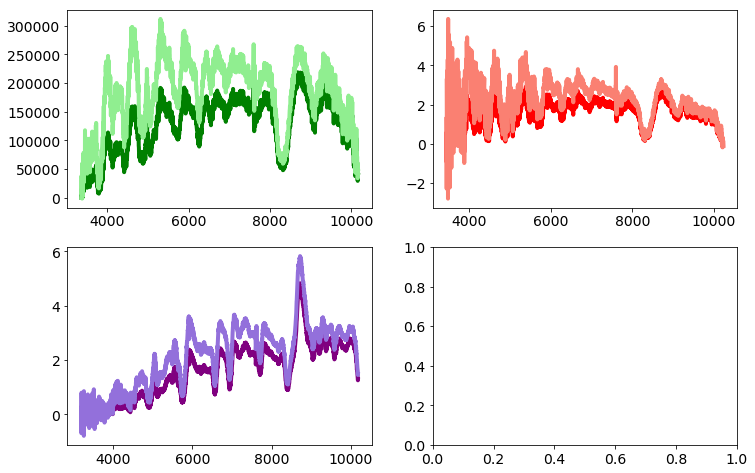

In [4]:
# Read in the spectra and plot include a test of the Cardelli function:
kast_Jan6 = ascii.read('Spectra/2019yvr-kast-20200106.flm',delimiter=' ',comment=';')
lris_Jan27 = ascii.read('Spectra/2019yvr-lris-20200127.flm',delimiter=' ',comment=';')
floyds_Jan2 = ascii.read('Spectra/2019yvr.20200102.FLOYDS-N.better.flm',delimiter=' ',comment=';')


test1 = Cardelli(floyds_Jan2['wave'],floyds_Jan2['flux'],0.5,2.1)
test2 = Cardelli(kast_Jan6['wave'],kast_Jan6['flux'],0.5,2.1)
test3 = Cardelli(lris_Jan27['wave'],lris_Jan27['flux'],0.5,2.1)

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure, subplots = plt.subplots(2, 2, figsize=(12,8))

subplots[0,0].plot(floyds_Jan2['wave'],floyds_Jan2['flux'],color='g',linewidth=4)
subplots[0,0].plot(floyds_Jan2['wave'],test1,color='lightgreen',linewidth=4)

subplots[0,1].plot(kast_Jan6['wave'],kast_Jan6['flux'],color='r',linewidth=4)
subplots[0,1].plot(kast_Jan6['wave'],test2,color='salmon',linewidth=4)

subplots[1,0].plot(lris_Jan27['wave'],lris_Jan27['flux'],color='purple',linewidth=4)
subplots[1,0].plot(lris_Jan27['wave'],test3,color='mediumpurple',linewidth=4)

plt.show()

## Initial Tests of the Extinction Correction Coefficients in this Framework:

In [170]:
# Information that I want:
# For each spectrum, for a tight grid of Rv, what is the A_labmda/E(B-V) value. 
# Ideally write out a table for each filter with Rv vs. epoch:

filters = ['g','r','r','B','V','u']
filter_resp = [g_filt,r_filt,i_filt,B_filt,V_filt,u_filt]
spectra = [floyds_Jan2, kast_Jan6, lris_Jan27, ]
Rv_list = np.linspace(1.0,6.0,num=61)


filters = ['g','r','i','B','V']
filter_resp = [g_filt,r_filt,i_filt,B_filt,V_filt]
spectra = [lris_Jan27]
#Rv_list = np.linspace(2.0,4.0,num=4)
Rv_list = np.array([2.1,3.1,4.1,5.1])
Av_list = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5])

Rv_list = np.array([2.8])
Av_list = np.array([1.7])

for i,filt in enumerate(filter_resp):
    for spec in spectra:
        for Rv in Rv_list:
            for Av in Av_list:
                EBmV = Av/Rv
            
                mag1 =  SyntheticPhotomQuick(spec['wave'],spec['flux'],filt)

                spec2_flux = Cardelli(spec['wave'],spec['flux'],Av,Rv)
                mag2 = SyntheticPhotomQuick(spec['wave'],spec2_flux,filt)
            
                A_lambda = mag1 - mag2
                coeff = A_lambda/EBmV
                print(filters[i],Rv,Av,EBmV,':',mag1,mag2,A_lambda,coeff)
            print('   ')


g 2.8 1.7 0.607142857143 : 25.3601962641 23.4086192702 1.95157699389 3.21436210759
   
r 2.8 1.7 0.607142857143 : 24.4834239915 23.0160104642 1.4674135273 2.4169163979
   
i 2.8 1.7 0.607142857143 : 24.1603900586 23.0523623876 1.108027671 1.82498675223
   
B 2.8 1.7 0.607142857143 : 25.9375579303 23.7107999823 2.22675794798 3.66760132609
   
V 2.8 1.7 0.607142857143 : 24.8037868259 23.1193868221 1.68440000376 2.77430588855
   


Some conclusions:
* I am getting different results for the coefficients than what is listed in SF11. I think that I am handling the EBmV things slightly differently than them for the ranges of Rv values. But I think now I am doing things in a consistent manner. 
* The coefficients are mostly constant for different Av values for a given Rv, they very by 0.02 - 0.1 mag (more so on the lower end of this), but do vary a bit. 
* For g-band extiction is lower for lower Rv. For r and i band it is the opposite; this agrees with SF11.
* Values are fairly close between the -5 day and +20 day spectra. g-band varies by 0.1 mag, i-band by 0.01. For now just assume a linear variation between those two sets of coefficients/extionctions. Could later add in more spectral series.

# Try running an actual grid in Rv and Av:
* calculate a Chi square between the full set of corrected color curves and the templates for each combination of Rv and Av
* Make a plot of Rv vs. Av with points color-coded based on Chi-square value.
* Start with the g-r, g-i, and r-i color curves that I have already. 

In [7]:
#Read in the color information and templates, etc.
gr_obs_temp = ascii.read("SN2019yvr_gr_color_temp.csv",delimiter=',')
gi_obs_temp = ascii.read("SN2019yvr_gi_color_temp.csv",delimiter=',')
ri_obs_temp = ascii.read("SN2019yvr_ri_color_temp.csv",delimiter=',')

#Grid for Results (takes a few minutes to run on laptop):
Rv_list = np.linspace(1.0,6.0,num=61)
Av_list = np.linspace(0.5,5.5,num=51)

#Test of common values:
#Rv_list = np.array([2.1,3.1,4.1,5.1])
#Av_list = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5])

#Test for a specific case:
#Rv_list = np.array([2.833])
#Av_list = np.array([1.7])

chi_results = np.zeros((len(Rv_list),len(Av_list)))

for i,Rv in enumerate(Rv_list):
    for j,Av in enumerate(Av_list):
        
        #Figure out gri corrections for both spectra for this combo of Rv and Av:
        A_g_floyds = A_lam(floyds_Jan2,g_filt,Rv,Av)
        A_r_floyds = A_lam(floyds_Jan2,r_filt,Rv,Av)
        A_i_floyds = A_lam(floyds_Jan2,i_filt,Rv,Av)
        
        A_g_lris = A_lam(lris_Jan27,g_filt,Rv,Av)
        A_r_lris = A_lam(lris_Jan27,r_filt,Rv,Av)
        A_i_lris = A_lam(lris_Jan27,i_filt,Rv,Av)
        
        #Interpolate the corrections in each band to be corrections at each time step in the three templates above:
        g_cor_grtimes = np.interp(gr_obs_temp['tg'],np.array([-5.0,20.0]),np.array([A_g_floyds,A_g_lris]))
        g_cor_gitimes = np.interp(gi_obs_temp['tg'],np.array([-5.0,20.0]),np.array([A_g_floyds,A_g_lris]))
        
        r_cor_grtimes = np.interp(gr_obs_temp['tg'],np.array([-5.0,20.0]),np.array([A_r_floyds,A_r_lris]))
        r_cor_ritimes = np.interp(ri_obs_temp['tr'],np.array([-7.0,18.0]),np.array([A_r_floyds,A_r_lris]))
        
        i_cor_gitimes = np.interp(gi_obs_temp['tg'],np.array([-5.0,20.0]),np.array([A_i_floyds,A_i_lris]))
        i_cor_ritimes = np.interp(ri_obs_temp['tr'],np.array([-7.0,18.0]),np.array([A_i_floyds,A_i_lris]))
        
        #Correct the three observed light curves for this amount of extinction:
        gr_obs_cor = gr_obs_temp['gr_obs'] - (g_cor_grtimes - r_cor_grtimes)
        gi_obs_cor = gi_obs_temp['gi_obs'] - (g_cor_gitimes - i_cor_gitimes)
        ri_obs_cor = ri_obs_temp['ri_obs'] - (r_cor_ritimes - i_cor_ritimes)
        
        #Calculate a Chi square between the corrected data and the template/errors. 
        gr_chi_sub1 = (gr_obs_cor - gr_obs_temp['gr_temp'])**2/gr_obs_temp['gr_temp_var']
        gi_chi_sub1 = (gi_obs_cor - gi_obs_temp['gi_temp'])**2/gi_obs_temp['gi_temp_var']
        ri_chi_sub1 = (ri_obs_cor - ri_obs_temp['ri_temp'])**2/ri_obs_temp['ri_temp_var']

        chi = np.sum(gr_chi_sub1)/len(gr_chi_sub1) + np.sum(gi_chi_sub1)/len(gi_chi_sub1) +np.sum(ri_chi_sub1)/len(ri_chi_sub1)

        #Save that value:
        chi_results[i,j] = chi

# Save those Chi values for ease of read-in/makeing plots:
np.save('Results/Resultsv1_Rv.npy',Rv_list)
np.save('Results/Resultsv1_Av.npy',Av_list)
np.save('Results/Resultsv1_chi.npy',chi_results)

## Make Some Summary Plots:

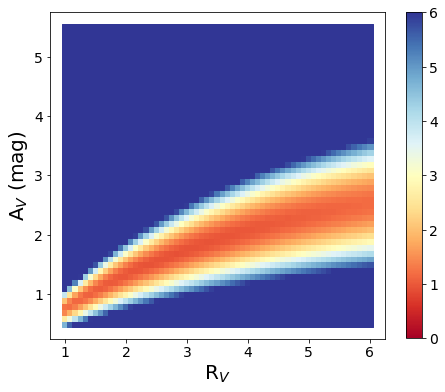

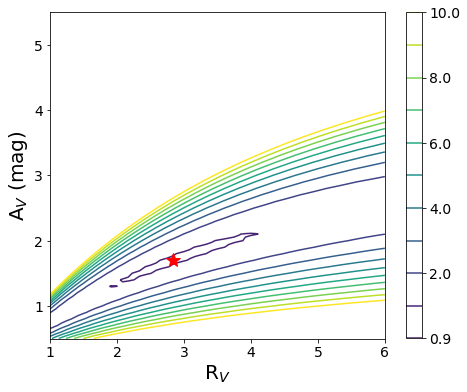

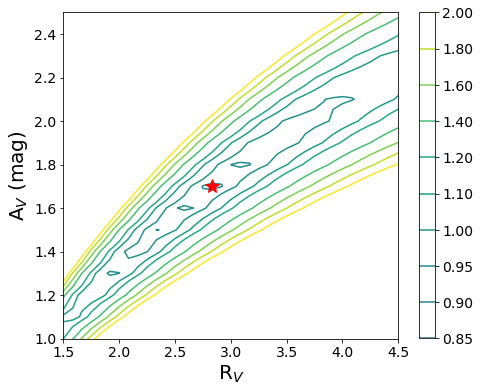

In [8]:
#Read in Data:
Rv_list = np.load('Results/Resultsv1_Rv.npy')
Av_list  = np.load('Results/Resultsv1_Av.npy')
chi_results = np.load('Results/Resultsv1_chi.npy')


## GENERAL Plot WITH POINTS Colored based on Chi-statistic:

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure, subplots = plt.subplots(1, 1, figsize=(7.5,6))

cm = plt.cm.get_cmap('RdYlBu')
for i in range(len(Rv_list)):
    Rv_plot = np.zeros(len(Av_list))+Rv_list[i]
    im = subplots.scatter(Rv_plot, Av_list, c=chi_results[i,:], vmin=0, vmax=6, cmap=cm, marker='s')
figure.colorbar(im,ax=subplots)

#Put sets of constant E(B-V):
#subplots.plot(Rv_list,Rv_list*0.25,color='lightgrey',linewidth=5)
#subplots.plot(Rv_list,Rv_list*0.5,color='darkgrey',linewidth=5)
#subplots.plot(Rv_list,Rv_list*0.75,color='grey',linewidth=5)

subplots.set_xlabel(r'R$_V$', fontsize=20) 
subplots.set_ylabel(r'A$_V$ (mag)', fontsize=20) 

subplots.set_xlim(0.75,6.25)
subplots.set_ylim(0.25,5.75)

plt.show()


#CONTOUR PLOTS V1:

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure2, subplots2 = plt.subplots(1, 1, figsize=(7.5,6))

Y, X = np.meshgrid(Av_list,Rv_list)
Z = chi_results
cp = subplots2.contour(X,Y,Z,levels=[0.9,1,2,3,4,5,6,7,8,9,10],vmin=0,vmax=10)
figure2.colorbar(cp) # Add a colorbar to a plot

subplots2.set_xlabel(r'R$_V$', fontsize=20) 
subplots2.set_ylabel(r'A$_V$ (mag)', fontsize=20) 

#Find the minimum value:
index = np.where(chi_results == np.min(chi_results))
subplots2.plot(Rv_list[index[0][0]],Av_list[index[1][0]],marker='*',markersize=15,color='red')
#print(Rv_list[index[0][0]],Av_list[index[1][0]])

plt.show()


#CONTOUR PLOTS V2 (ZOOM):

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure2, subplots2 = plt.subplots(1, 1, figsize=(7.5,6))

Y, X = np.meshgrid(Av_list,Rv_list)
Z = chi_results
cp = subplots2.contour(X,Y,Z,levels=[0.85,0.9,0.95,1,1.1,1.2,1.4,1.6,1.8,2.0],vmin=0,vmax=2)
figure2.colorbar(cp) # Add a colorbar to a plot

subplots2.set_xlabel(r'R$_V$', fontsize=20) 
subplots2.set_ylabel(r'A$_V$ (mag)', fontsize=20) 

subplots2.set_xlim(1.5,4.5)
subplots2.set_ylim(1,2.5)

#Find the minimum value:
index = np.where(chi_results == np.min(chi_results))
subplots2.plot(Rv_list[index[0][0]],Av_list[index[1][0]],marker='*',markersize=15,color='red')

plt.show()


### Plot for how well colors agree 
Note: This only works if you run the test case above with the best fit values in it. 

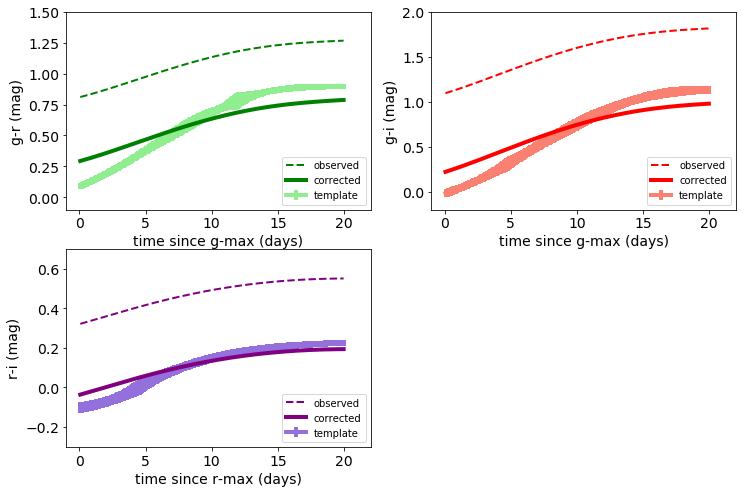

In [10]:
# Plot how well the color curves agree based on this best-fit value:

##Plot those colors and include the templates:
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure, subplots = plt.subplots(2, 2, figsize=(12,8))

subplots[0,0].plot(gr_obs_temp['tg'],gr_obs_temp['gr_obs'],color='g',linewidth=2,linestyle='--',label='observed')
subplots[0,0].errorbar(gr_obs_temp['tg'],gr_obs_temp['gr_temp'],gr_obs_temp['gr_temp_var'],color='lightgreen',linewidth=4,linestyle='-',zorder=1,label='template')
subplots[0,0].plot(gr_obs_temp['tg'],gr_obs_cor,color='g',linewidth=4,label='corrected')

subplots[0,1].plot(gi_obs_temp['tg'],gi_obs_temp['gi_obs'],color='r',linewidth=2,linestyle='--',label='observed')
subplots[0,1].errorbar(gi_obs_temp['tg'],gi_obs_temp['gi_temp'],gi_obs_temp['gi_temp_var'],color='salmon',linewidth=4,linestyle='-',zorder=1,label='template')
subplots[0,1].plot(gi_obs_temp['tg'],gi_obs_cor,color='r',linewidth=4,label='corrected')

subplots[1,0].plot(ri_obs_temp['tr'],ri_obs_temp['ri_obs'],color='purple',linewidth=2,linestyle='--',label='observed')
subplots[1,0].errorbar(ri_obs_temp['tr'],ri_obs_temp['ri_temp'],ri_obs_temp['ri_temp_var'],color='mediumpurple',linewidth=4,linestyle='-',zorder=1,label='template')
subplots[1,0].plot(ri_obs_temp['tr'],ri_obs_cor,color='purple',linewidth=4,label='corrected')


subplots[0,0].set_xlim(-1,22)
subplots[0,0].set_ylim(-0.1,1.5)
subplots[0,0].set_xlabel(r'time since g-max (days)', fontsize=14) 
subplots[0,0].set_ylabel(r'g-r (mag)', fontsize=14) 
subplots[0,0].legend(loc='lower right')

subplots[0,1].set_xlim(-1,22)
subplots[0,1].set_ylim(-0.2,2)
subplots[0,1].set_xlabel(r'time since g-max (days)', fontsize=14) 
subplots[0,1].set_ylabel(r'g-i (mag)', fontsize=14) 
subplots[0,1].legend(loc='lower right')

subplots[1,0].set_xlim(-1,22)
subplots[1,0].set_ylim(-0.3,0.7)
subplots[1,0].set_xlabel(r'time since r-max (days)', fontsize=14) 
subplots[1,0].set_ylabel(r'r-i (mag)', fontsize=14) 
subplots[1,0].legend(loc='lower right')

subplots[1,1].axis('off')

plt.show()